In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.utils import pad_sequences
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv("politifact_data.csv")
df.drop_duplicates(subset = ['claim'], keep = 'last', inplace = True)
x_train, x_test, y_train, y_test = train_test_split(df['claim'], df['accuracy'], random_state = 42, test_size = 0.2)

In [3]:
x_train.shape

(13450,)

In [4]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [5]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(x_train)
x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

In [6]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
lr_clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
lr_clf.fit(x_train_tfv, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       0.53      0.37      0.43      1512
           1       0.59      0.73      0.65      1851

    accuracy                           0.57      3363
   macro avg       0.56      0.55      0.54      3363
weighted avg       0.56      0.57      0.55      3363



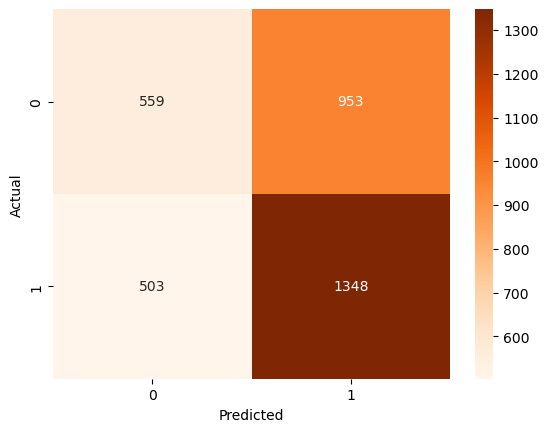

In [7]:
score_model(lr_clf, x_test_tfv, y_test)

In [8]:
print("Best combination of hyperparams:\n", lr_clf.best_params_, "\n")
print("Best mean_test_score score:\n", lr_clf.best_score_, "\n")

Best combination of hyperparams:
 {'C': 1.0, 'penalty': 'l2'} 

Best mean_test_score score:
 0.5777695167286246 



              precision    recall  f1-score   support

           0       0.52      0.29      0.37      1512
           1       0.57      0.78      0.66      1851

    accuracy                           0.56      3363
   macro avg       0.55      0.54      0.52      3363
weighted avg       0.55      0.56      0.53      3363



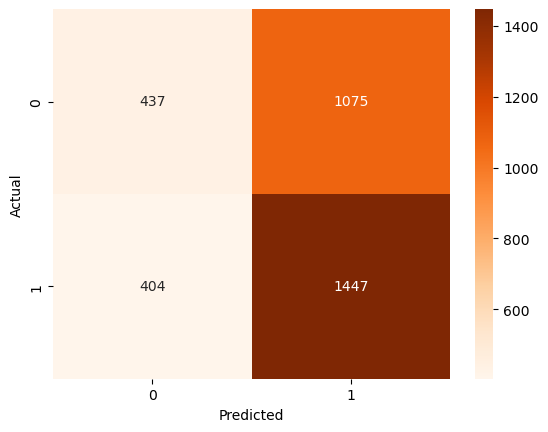

In [9]:
nb_clf = MultinomialNB()
nb_clf.fit(x_train_tfv, y_train)
score_model(nb_clf, x_test_tfv, y_test)

              precision    recall  f1-score   support

           0       0.52      0.30      0.38      1512
           1       0.57      0.77      0.66      1851

    accuracy                           0.56      3363
   macro avg       0.55      0.54      0.52      3363
weighted avg       0.55      0.56      0.53      3363



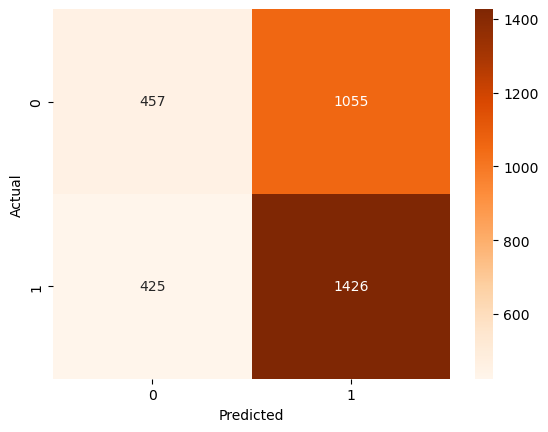

In [21]:
svc_clf = SVC()
svc_clf.fit(x_train_tfv, y_train)
score_model(svc_clf, x_test_tfv, y_test)

In [11]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}

# gd=GridSearchCV(estimator=SVC(),param_grid=param_grid,verbose=True)

# gd.fit(x_train_tfv, y_train)
# print(gd.best_score_)
# print(gd.best_estimator_)

[16:00:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.52      0.28      0.37      1512
           1       0.57      0.79      0.66      1851

    accuracy                           0.56      3363
   macro avg       0.55      0.53      0.52      3363
weighted avg       0.55      0.56      0.53      3363



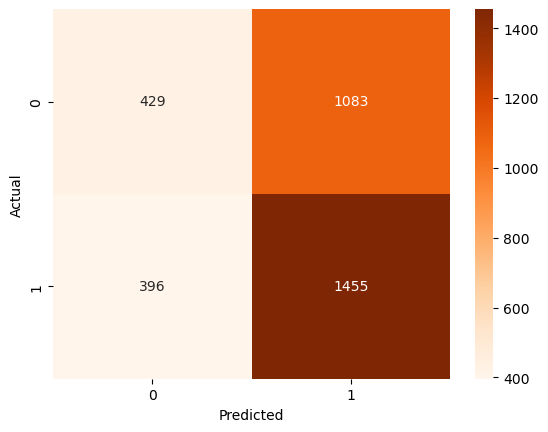

In [12]:
xg_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, use_label_encoder=False)
xg_clf.fit(x_train_tfv, y_train)
score_model(xg_clf, x_test_tfv, y_test)

In [13]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(x_train)
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

In [14]:
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding ="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
    embeddings_index[word] = coefs
f.close()

2196017it [02:48, 13051.10it/s]


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 17231/17231 [00:00<00:00, 380605.58it/s]


In [18]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences = True))
lstm_model.add(tf.keras.layers.GlobalMaxPooling1D())

lstm_model.add(Dense(1024, activation='relu'))
lstm_model.add(Dropout(0.8))

lstm_model.add(Dense(1024, activation='relu'))
lstm_model.add(Dropout(0.8))

lstm_model.add(Dense(1))
lstm_model.add(Activation('sigmoid'))
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics = ['accuracy'])

In [19]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
lstm = lstm_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 25s 734ms/step - loss: 0.6968 - accuracy: 0.5396 - val_loss: 0.6881 - val_accuracy: 0.5504
Epoch 2/100
27/27 [==============================] - 20s 748ms/step - loss: 0.6881 - accuracy: 0.5518 - val_loss: 0.6867 - val_accuracy: 0.5501
Epoch 3/100
27/27 [==============================] - 20s 743ms/step - loss: 0.6860 - accuracy: 0.5511 - val_loss: 0.6837 - val_accuracy: 0.5507
Epoch 4/100
27/27 [==============================] - 20s 728ms/step - loss: 0.6824 - accuracy: 0.5616 - val_loss: 0.6816 - val_accuracy: 0.5599
Epoch 5/100
27/27 [==============================] - 22s 801ms/step - loss: 0.6801 - accuracy: 0.5636 - val_loss: 0.6803 - val_accuracy: 0.5605
Epoch 6/100
27/27 [==============================] - 28s 1s/step - loss: 0.6752 - accuracy: 0.5700 - val_loss: 0.6783 - val_accuracy: 0.5671
Epoch 7/100
27/27 [==============================] - 25s 921ms/step - loss: 0.6727 - accuracy: 0.5787 - val_loss: 0.6791 - val_accuracy: 0.

In [20]:
gru_model = Sequential()
gru_model.add(tf.keras.layers.Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(tf.keras.layers.GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
gru_model.add(tf.keras.layers.GRU(300, dropout=0.3, recurrent_dropout=0.3))

gru_model.add(Dense(1024, activation='relu'))
gru_model.add(Dropout(0.8))

gru_model.add(Dense(1024, activation='relu'))
gru_model.add(Dropout(0.8))

gru_model.add(Dense(1))
gru_model.add(Activation('sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
gru = gru_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 81s 3s/step - loss: 0.7006 - accuracy: 0.5324 - val_loss: 0.6880 - val_accuracy: 0.5442
Epoch 2/100
27/27 [==============================] - 77s 3s/step - loss: 0.6927 - accuracy: 0.5479 - val_loss: 0.6866 - val_accuracy: 0.5510
Epoch 3/100
27/27 [==============================] - 80s 3s/step - loss: 0.6919 - accuracy: 0.5467 - val_loss: 0.6856 - val_accuracy: 0.5510
Epoch 4/100
27/27 [==============================] - 75s 3s/step - loss: 0.6852 - accuracy: 0.5625 - val_loss: 0.6856 - val_accuracy: 0.5501
Epoch 5/100
27/27 [==============================] - 76s 3s/step - loss: 0.6817 - accuracy: 0.5660 - val_loss: 0.6857 - val_accuracy: 0.5483
Epoch 6/100
27/27 [==============================] - 76s 3s/step - loss: 0.6812 - accuracy: 0.5589 - val_loss: 0.6844 - val_accuracy: 0.5436
Epoch 7/100
27/27 [==============================] - 74s 3s/step - loss: 0.6770 - accuracy: 0.5738 - val_loss: 0.6860 - val_accuracy: 0.5433
Epoch 8/100
2